# CEP Pairs

In [1]:
include("src/Misc.jl");
include("src/Datasets.jl");

In [2]:
using .Misc
import .Datasets

In [3]:
using Statistics, Distributions
using SpecialFunctions, LinearAlgebra
import Random: randperm, seed!

using PyPlot
seed!(1000);

In [4]:
MARKER = ["o", "v", "d", "X", "p", "*", "P"];
RESULTS_PATH = "./results/tuebingen/vb";
PARAMS_PATH = "./params";

N_PARAMS = 36

36

In [5]:
function split_data(N,K)
    splits = fill(Int(floor(N/K)),K)
    splits[1:(N%K)] .+= 1
    return [0; cumsum(splits)]
end

split_data (generic function with 1 method)

In [6]:
function accuracy(models,g_truth; weights=ones(length(models)))
    return sum((models .== g_truth) .* weights) / sum(weights)
end

accuracy (generic function with 1 method)

In [7]:
function spurious_pairs(models)
    return (1:length(models))[(models .== 3)[:,1]]
end

spurious_pairs (generic function with 1 method)

## Read Results

In [8]:
valid_pairs = setdiff(1:100,[52,53,54,55,71])
tuebingen_data = Datasets.tuebingen(valid_pairs);

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


In [9]:
CEP_datasets = Dict(
    "Abalone" => [5,6,7,8,9,10,11],
    "Armagan Tarim" => [89,90,91],
    "Armann & Buelthoff" => [66],
    "arrhythmia" => [22,23,24],
    "auto-mpg" => [13,14,15,16],
    "Bafu" => [49,50,51],
    "bone-dataset" => [83],
    "B.Janzing" => [42,72],
    "census income" => [12,17],
    "concrete_data" => [25,26,27,28,29,30,31,32],
    "cpus" => [95],
    "DWD" => [1,2,3,4,20,21],
    "D.Janzing" => [92,93],
    "Food and Agriculture" => [71],
    "GAGurine" => [18],
    "geyser" => [19],
    "Hipel & Mcleod" => [48],
    "liver_orders" => [33,34,35,36,37],
    "Mahecha, M." => [76,77,78],
    "Moffat A.M." => [73,74,75],
    "Mooij" => [65],
    "Mooij2" => [81],
    "Mopex" => [88],
    "ncep-ncar" => [43,44,45,46],
    "nlschools" => [94],
    "Oswald" => [80],
    "pima indian diabetes" =>[38,39,40,41],
    "Plant and Soil" => [84,85,86,87],
    "P.Stark" => [64],
    "spatial-econometrics" => [79],
    "sunspot" => [67],
    "traffic" => [47],
    "UNdata" => [52,53,54,55,56,57,58,59,60,68,69,70],
    "whistler-daily-snowfall" => [82],
    "Yahoo" => [61,62,63]
);

In [10]:
DS = [values(CEP_datasets)...];

In [11]:
N_data = length(valid_pairs)
N_datasets = length(CEP_datasets)
N_mid = Int(ceil(N_datasets/2))

18

In [12]:
params = [Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$n.json"))
                                      for n ∈ 1:N_PARAMS];

In [13]:
results = zeros(N_PARAMS,N_data,3,5,3)

for n ∈ 1:N_PARAMS, pair ∈ 1:length(valid_pairs)
    result = load_json("$RESULTS_PATH/params-$n/$(tuebingen_data[pair][:id]).json")["scores"]
    for dir ∈ 1:3, r ∈ 1:5, m ∈ 1:3
        results[n,pair,dir,r,m] = result[m][r][dir]
    end
end

In [14]:
ground_truth = ['>' in pair[:relationship] ? 1 : 2 for pair ∈ tuebingen_data];
weights = [pair[:weight] for pair ∈ tuebingen_data];

## Empirical Bayes

In [15]:
labels_eb = [findmax(nanmax(results[:,n,1:2,:,:],(1,3,4)))[2] for n ∈ 1:N_data]
accuracy(labels_eb,ground_truth;weights=weights)

0.48576914614876887

In [16]:
labels_all = [findmax(nanmax(results[p,n,:,:,:],(2,3)))[2] for p ∈ 1:N_PARAMS, n ∈ 1:N_data];
labels_two = [findmax(nanmax(results[p,n,1:2,:,:],(2,3)))[2] for p ∈ 1:N_PARAMS, n ∈ 1:N_data];

## $M \times K$ Cross Validation 

In [17]:
M, K = 10, 3
performance = zeros(M,K);
splits = split_data(length(valid_pairs),K);

In [18]:
for m ∈ 1:M
    perm_pairs = randperm(N_data)
    for k ∈ 1:K
        test = perm_pairs[splits[k]+1:splits[k+1]]
        train = setdiff(perm_pairs,test)
    
        tr_acc = [accuracy(labels_two[n,train], ground_truth[train]; weights=weights[train]) for n ∈ 1:N_PARAMS]
        p_setting = findmax(tr_acc)[2]
        performance[m,k] = accuracy(labels_two[p_setting,test], ground_truth[test]; weights=weights[test])
    end
end

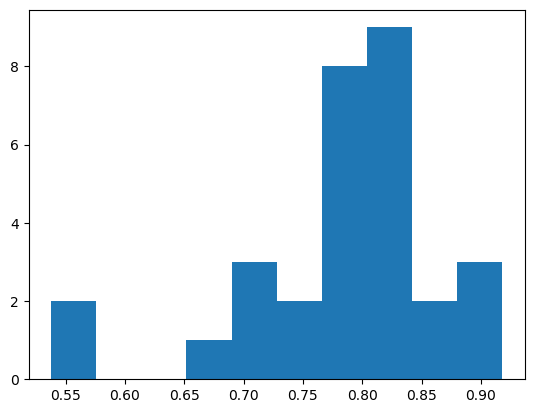

%68 CI => 0.7851950373637865 ± 0.08809025477375333


In [19]:
PyPlot.hist(performance[:]);
println("%68 CI => $(nanmean(performance)) ± $(nanstd(performance))")

# ROC (K-fold)

In [20]:
M, K = 10, 3
AUCs = zeros(M,K)
splits = split_data(length(valid_pairs),K);

In [21]:
for m ∈ 1:M
    perm_pairs = randperm(N_data)
    for k ∈ 1:K
        test = perm_pairs[splits[k]+1:splits[k+1]]
        train = setdiff(perm_pairs,test)
    
        tr_acc = [accuracy(labels_two[n,train], ground_truth[train]; weights=weights[train]) for n ∈ 1:N_PARAMS]
        p_setting = findmax(tr_acc)[2]
        
        score = nanmax(results[p_setting,test,1,:,:],(2,3)) .- nanmax(results[p_setting,test,2,:,:],(2,3))
        AUCs[m,k] = AUC(score, ground_truth[test], 1; weights=weights[test])
    end    
end

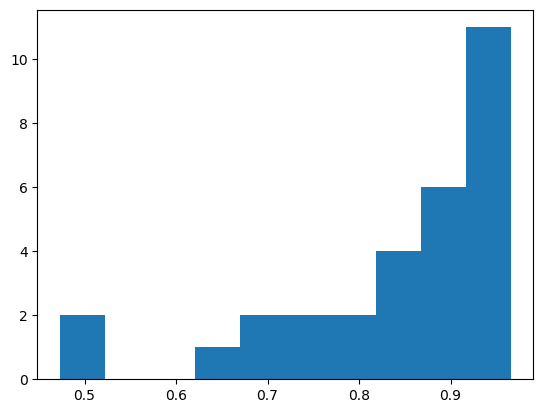

%68 CI => 0.840990629340226 ± 0.12944816732391592


In [22]:
PyPlot.hist(AUCs[:]);
println("%68 CI => $(nanmean(AUCs)) ± $(nanstd(AUCs))")

## Accuracy of Each Parameter

In [23]:
acc = [accuracy(labels_two[n,:],ground_truth; weights=weights) for n ∈ 1:N_PARAMS];
findmax(acc)

(0.8234922666788579, 13)

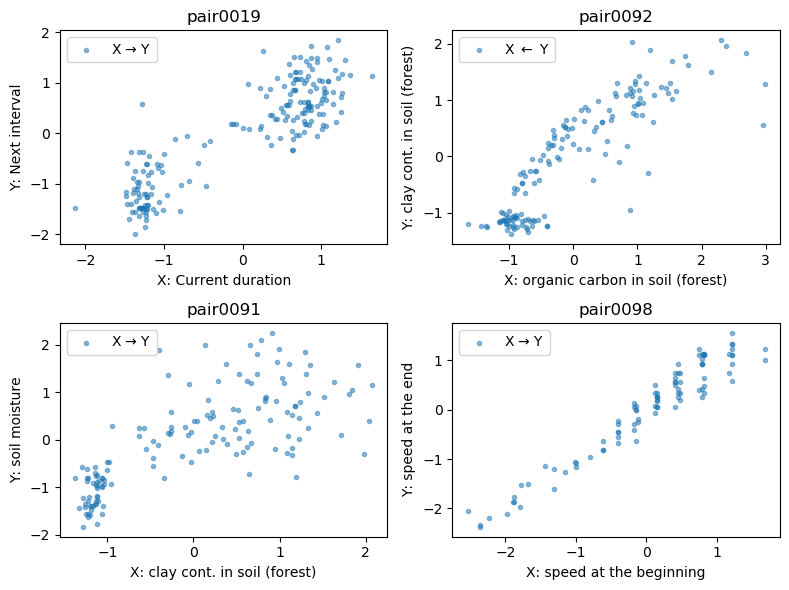

In [27]:
spr_pairs = [19, 86, 87, 93]
R, C = 2, Int(ceil(length(spr_pairs)/2))
fig, ax = PyPlot.subplots(2,2,figsize=(4*C,R*3))

for (ord, pr) ∈ enumerate(spr_pairs)
    plot_pair(tuebingen_data[pr]; ax=ax[ord], normalize=true, alpha=0.5)
    ax[ord].set_title(tuebingen_data[pr][:id])
end
PyPlot.tight_layout()
PyPlot.savefig("./img/spr_pairs.pdf", bbox_inches="tight");

In [28]:
[findmax(results[13,n,:,3])[2] for n ∈ spr_pairs]

BoundsError: BoundsError: attempt to access 36×95×3×5×3 Array{Float64,5} at index [20, 19, Base.Slice(Base.OneTo(3)), 3]

In [33]:
params[13]

Dict{Symbol,Any} with 13 entries:
  :b₁   => 10.0
  :Rs   => Any[1, 2, 3, 4, 5]
  :a₂   => 10.0
  :m₁   => 0.0
  :λ₁   => 0.1
  :a₁   => 100.0
  :name => "params-13"
  :γ    => 10.0
  :P    => 1000
  :Ms   => Any[2, 3, 4]
  :λ₂   => 0.1
  :m₂   => 0.0
  :b₂   => 1.0

## Tables

In [29]:
import Printf: @sprintf

In [30]:
bottom = """\\hline
\\end{tabular}"""

top = """
\\begin{tabular}{|ll|rrrrrrr|}
\\hline
 & \\# & \$\\gamma_1\$ & \$\\lambda_{n \\mid r_1}\$ & \$m_{n \\mid r_1}\$ & \$a_1\$ & \$b_1\$ & \$a_2\$ & \$b_2\$ \\\\
\\hline
\\multirow{36}{*}{\\rotatebox[origin=c]{90}{\\textsc{Hyperparameter Setting}}}
"""

middle = ""
for pr in 1:N_PARAMS
    a₁, a₂, b₁, b₂ = params[pr][:a₁], params[pr][:a₂], params[pr][:b₁], params[pr][:b₂]
    middle *= " & $(pr) & 10.0 & 0.1 & 0.0 & $(a₁) & $(b₁) & $(a₂) & $(a₂) \\\\\n"
end

print(top*middle*bottom)

\begin{tabular}{|ll|rrrrrrr|}
\hline
 & \# & $\gamma_1$ & $\lambda_{n \mid r_1}$ & $m_{n \mid r_1}$ & $a_1$ & $b_1$ & $a_2$ & $b_2$ \\
\hline
\multirow{36}{*}{\rotatebox[origin=c]{90}{\textsc{Hyperparameter Setting}}}
 & 1 & 10.0 & 0.1 & 0.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
 & 2 & 10.0 & 0.1 & 0.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
 & 3 & 10.0 & 0.1 & 0.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
 & 4 & 10.0 & 0.1 & 0.0 & 100.0 & 10.0 & 100.0 & 100.0 \\
 & 5 & 10.0 & 0.1 & 0.0 & 100.0 & 10.0 & 100.0 & 100.0 \\
 & 6 & 10.0 & 0.1 & 0.0 & 100.0 & 10.0 & 100.0 & 100.0 \\
 & 7 & 10.0 & 0.1 & 0.0 & 100.0 & 1.0 & 100.0 & 100.0 \\
 & 8 & 10.0 & 0.1 & 0.0 & 100.0 & 1.0 & 100.0 & 100.0 \\
 & 9 & 10.0 & 0.1 & 0.0 & 100.0 & 1.0 & 100.0 & 100.0 \\
 & 10 & 10.0 & 0.1 & 0.0 & 100.0 & 100.0 & 10.0 & 10.0 \\
 & 11 & 10.0 & 0.1 & 0.0 & 100.0 & 100.0 & 10.0 & 10.0 \\
 & 12 & 10.0 & 0.1 & 0.0 & 100.0 & 10.0 & 10.0 & 10.0 \\
 & 13 & 10.0 & 0.1 & 0.0 & 100.0 & 10.0 & 10.0 & 10.0 \\
 & 14 & 10.0 & 0.1 & 0.0 & 100

In [31]:
bottom = """\\hline
\\end{tabular}"""

top = """
\\begin{tabular}{|ll|rrrr|}
\\hline
 & \\# & \$\\to\$ & \$\\leftarrow\$ & \$\\wedge\$ & \\textsc{Accuracy} \\\\
\\hline
\\multirow{36}{*}{\\rotatebox[origin=c]{90}{\\textsc{Hyperparameter Setting}}}
"""

middle = ""
for pr in 1:N_PARAMS
    x2y = sum(labels_all[pr,:] .== 1)
    y2x = sum(labels_all[pr,:] .== 2)
    xry = sum(labels_all[pr,:] .== 3)
    acc_pr = @sprintf("%.2f",acc[pr])
    middle *= " & $(pr) & $(x2y) & $(y2x) & $(xry) & $(acc_pr) \\\\\n"
end

print(top*middle*bottom)

\begin{tabular}{|ll|rrrr|}
\hline
 & \# & $\to$ & $\leftarrow$ & $\wedge$ & \textsc{Accuracy} \\
\hline
\multirow{36}{*}{\rotatebox[origin=c]{90}{\textsc{Hyperparameter Setting}}}
 & 1 & 0 & 0 & 95 & 0.50 \\
 & 2 & 1 & 0 & 94 & 0.35 \\
 & 3 & 2 & 0 & 93 & 0.31 \\
 & 4 & 0 & 0 & 95 & 0.73 \\
 & 5 & 0 & 1 & 94 & 0.60 \\
 & 6 & 2 & 1 & 92 & 0.37 \\
 & 7 & 0 & 1 & 94 & 0.75 \\
 & 8 & 1 & 2 & 92 & 0.75 \\
 & 9 & 0 & 2 & 93 & 0.61 \\
 & 10 & 1 & 0 & 94 & 0.48 \\
 & 11 & 2 & 0 & 93 & 0.35 \\
 & 12 & 0 & 1 & 94 & 0.72 \\
 & 13 & 2 & 1 & 92 & 0.82 \\
 & 14 & 0 & 2 & 93 & 0.73 \\
 & 15 & 1 & 2 & 92 & 0.73 \\
 & 16 & 2 & 0 & 93 & 0.42 \\
 & 17 & 2 & 1 & 92 & 0.80 \\
 & 18 & 1 & 2 & 92 & 0.71 \\
 & 19 & 0 & 0 & 95 & 0.58 \\
 & 20 & 0 & 1 & 94 & 0.29 \\
 & 21 & 2 & 1 & 92 & 0.30 \\
 & 22 & 0 & 1 & 94 & 0.72 \\
 & 23 & 1 & 2 & 92 & 0.29 \\
 & 24 & 3 & 1 & 91 & 0.28 \\
 & 25 & 0 & 1 & 94 & 0.57 \\
 & 26 & 2 & 1 & 92 & 0.37 \\
 & 27 & 1 & 2 & 92 & 0.70 \\
 & 28 & 1 & 2 & 92 & 0.65 \\
 & 29 & 2 & 1 & 9